# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**<u>Описание данных</u>**

Данные находятся в файле `/datasets/autos.csv`.

**Признаки**

* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**

* `Price` — цена (евро)

**<u>План работы</u>**

**1.** Загрузка данных из файла `/datasets/autos.csv` и их подготовка к дальнейшей работе.

**2.** Изучение данных. Заполнение пропущенных значений и обработка аномалий в столбцах. Если среди признаков имеются неинформативные, их необходимо удалить.

**3.** Подготовка выборки для обучения моделей.

**4.** Обучение разных моделей, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать использовать разные гиперпараметры.

**5.** Анализ времени обучения, времени предсказания и качества моделей.

**6.** Выбор лучшей модели (на основе критериев заказчика), проверка её качества на тестовой выборке.

<u>Примечания</u>

* Для оценки качества моделей рекомендуется применять метрику `RMSE`.
* Значение метрики `RMSE` должно быть меньше `2500`.
* Рекмендуется самостоятельно изучить библиотеку `LightGBM` и её средствами построить модели градиентного бустинга.
* Время выполнения ячейки кода `Jupyter Notebook` нужно получить специальной командой.
* Модель градиентного бустинга может долго обучаться, поэтому нужно изменить у неё только два-три параметра.
* Если перестанет работать `Jupyter Notebook`, рекомендуется удалить лишние переменные оператором `del` (`del features_train`).

---------------------------

**Импорт необходимых для работы библиотек**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

pd.set_option('display.max_columns', None)

%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 4)

RANDOM_STATE = 42

## Загрузка и подготовка данных

In [2]:
# сохраним датафрейм в переменную
data = pd.read_csv('datasets/autos.csv')

In [3]:
# посмотрим общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# просмотрим первые строки датафрейма
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Итак, мы видим, что в данных есть пропуски (столбцы `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`), названия колонок не соответствуют стандарту `snake_case`, тип данных в столбцах с датами необходимо изменить с `object` на `datetime`.

Для начала изменим названия столбцов в соответствии с общепринятым стандартом. Поскольку некоторые названия столбцов состоят из одного слова, переведем их в нижний регистр для удобства.


In [5]:
data.columns = data.columns.str.lower()

Теперь исправим названия столбцов, состоящие из нескольких слов, используя `snake_case`.

In [6]:
data = data.rename(
    columns={
        'datecrawled': 'date_crawled',
        'vehicletype': 'vehicle_type',
        'registrationyear': 'registration_year',
        'registrationmonth': 'registration_month',
        'fueltype': 'fuel_type',
        'notrepaired': 'not_repaired',
        'datecreated': 'date_created',
        'numberofpictures': 'number_of_pictures',
        'postalcode': 'postal_code',
        'lastseen': 'last_seen'
    }
)

Посмотрим, что получилось.

In [7]:
data.sample()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
244997,2016-03-10 11:46:56,2550,convertible,2003,auto,41,fortwo,150000,8,gasoline,smart,no,2016-03-10 00:00:00,0,44809,2016-03-20 18:47:38


Названия столбцов успешно исправлены.

Теперь изменим тип данных в столбцах с датами на с `object` на `datetime`.

In [8]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S')
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')
data['last_seen'] = pd.to_datetime(data['last_seen'], format='%Y-%m-%d %H:%M:%S')

Посмотрим, что получилось.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

Итак, тип данных успешно изменен.

**Вывод:**

Датафрейм загружен, названия столбцов датафрейма приведены в соответствие с принятым стандартом, тип данных в столбцах с датами был изменен на соответствующий.

## Изучение данных

Теперь приступим к изучению данных. Для начала проверим наличие явных дубликатов, и, если они есть, удалим их.

In [10]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 4


In [11]:
data = data.drop_duplicates().reset_index(drop=True)

In [12]:
print('Количество явных дубликатов после удаления:', data.duplicated().sum())

Количество явных дубликатов после удаления: 0


Явные дубликаты успешно удалены.

Теперь проверим наличие аномальных значений в количественных признаках, начнем с года регистрации автомобиля.

In [13]:
data['registration_year'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

В результате видим, что в этом столбце присутствуют аномалии: минимальное значение года — `1000`, максимальное — `9999`.

Поскольку год регистрации автомобиля не может быть позже последней даты скачивания анкеты из базы, узнаем ее.

In [14]:
data['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

Отберем автомобили с реалистичными годами регистрации.

In [15]:
data = data.query('1910 < registration_year <= 2016')

Построим гистограмму, чтобы посмотреть распределение годов регистрации и выбрать нижнюю границу.

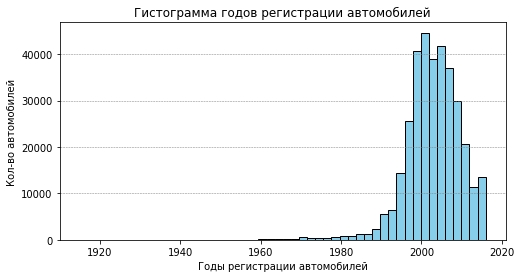

In [17]:
plt.hist(data['registration_year'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Годы регистрации автомобилей')
plt.ylabel('Кол-во автомобилей')
plt.title('Гистограмма годов регистрации автомобилей')
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.show();

Исходя из полученной гистограммы и учитывая последнюю дату скачивания анкеты из базы, сохраним в датафрейме значения года регистрации автомобиля, начиная `с 1960 по 2016`.

In [18]:
data = data.query('1960 <= registration_year <= 2016')

Проверим, что получилось.

In [19]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,339413.000000,339413.000000,339413.000000,339413.000000,339413.000000,339413.0,339413.000000
mean,4469.917885,2002.549684,111.074809,128152.840345,5.758934,0.0,50608.649159
std,4543.710777,6.752072,186.926210,37813.335030,3.707695,0.0,25803.576219
min,0.000000,1960.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1100.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30169.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49492.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество объектов в датафрейме сократилось до `339413`. Минимальное значение года регистрации автомобиля — `1960`, максимальное — `2016`.

Теперь рассмотрим столбец, содержащий данные о мощности автомобилей (л.с.).

In [20]:
data['power'].describe()

count    339413.000000
mean        111.074809
std         186.926210
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Опять видим аномальные значения: минимальное количество лошадиных сил — `0`, максимальное — `20000`.

<u>Справка из Интернета</u>

Nissan GT-R AMS Alpha 12 возглавляет список самых мощных машин в мире. Автомобиль был разработан японской компанией AMS Performance, которой удалось создать настоящего зверя дорог. Nissan GT-R AMS Alpha 12 с мощным турбодвигателем имеет 1500 лошадиных сил. Данный рекорд не удалось побить пока еще ни одной модели.

Исходя из этого, возьмем значение 1500 л.с. как максимальное и проверим распределение данных на гистограмме.

In [21]:
data = data.query('power < 1500')

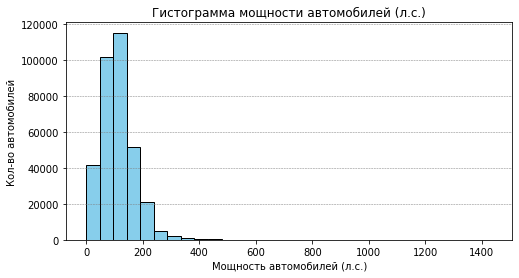

In [23]:
plt.hist(data['power'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Мощность автомобилей (л.с.)')
plt.ylabel('Кол-во автомобилей')
plt.title('Гистограмма мощности автомобилей (л.с.)')
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.show();

Исходя из полученной гистограммы, установим верхнюю границу в `500` л.с., а нулевые и околонулевые значения удалим. На просторах Интернета обнаружила автомобиль Peugeot VLV (1941 г) с мощностью 3 л.с., будем считать это значение минимальным.

In [24]:
data = data.query('3 <= power <= 500')

Посмотрим, что получилось.

In [25]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,302698.000000,302698.000000,302698.000000,302698.000000,302698.000000,302698.0,302698.000000
mean,4748.840247,2002.778086,120.432956,128387.237445,5.965252,0.0,51117.731538
std,4612.476391,6.473396,53.561403,36815.551904,3.599388,0.0,25809.291409
min,0.000000,1960.000000,3.000000,5000.000000,0.000000,0.0,1067.000000
25%,1250.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30880.000000
50%,3000.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,50169.000000
75%,6900.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,71711.000000
max,20000.000000,2016.000000,500.000000,150000.000000,12.000000,0.0,99998.000000


Количество объектов в датафрейме сократилось до `302698`. Минимальное значение количества лошадиных сил — `3`, максимальное — `500`.

Теперь рассмотрим столбец цены.

In [26]:
data['price'].describe()

count    302698.000000
mean       4748.840247
std        4612.476391
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: price, dtype: float64

Цена автомобиля может быть любой, но не равной нулю, поэтому удалим эти значения, поскольку признак целевой.

In [27]:
data = data.query('0 < price')

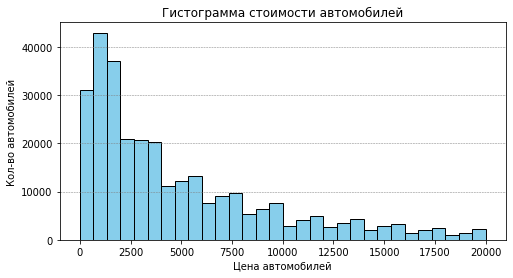

In [29]:
plt.hist(data['price'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Цена автомобилей')
plt.ylabel('Кол-во автомобилей')
plt.title('Гистограмма стоимости автомобилей')
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.show();

Посмотрим, что получилось.

In [30]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,296318.000000,296318.000000,296318.000000,296318.000000,296318.000000,296318.0,296318.000000
mean,4851.087160,2002.842737,120.527433,128300.980703,5.993922,0.0,51239.354329
std,4608.361824,6.438069,53.533103,36757.543106,3.583865,0.0,25781.281731
min,1.000000,1960.000000,3.000000,5000.000000,0.000000,0.0,1067.000000
25%,1349.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30926.000000
50%,3200.000000,2003.000000,111.000000,150000.000000,6.000000,0.0,50259.000000
75%,6999.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72108.000000
max,20000.000000,2016.000000,500.000000,150000.000000,12.000000,0.0,99998.000000


Количество объектов в датафрейме сократилось до `296318`. Минимальное значение цены — `1`, максимальное — `20000`.

В датафрейме присутствуют признаки, которые не содержат данные об автомобилях, поэтому не являются важными и не нужны для обучения моделей. Таким образом, удалим из датафрейма дату скачивания анкеты из базы, месяц регистрации автомобиля, дату создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты и дату последней активности пользователя.

In [31]:
data = data.drop(
    columns=[
        'date_crawled',
        'registration_month',
        'date_created',
        'number_of_pictures',
        'postal_code',
        'last_seen'
    ]
)

Проверим, какие столбцы остались.

In [32]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

Поскольку была удалена часть лишних признаков, в данных могли появиться новые явные дубликаты, проверим это.

In [33]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 39083


Действительно, появилось очень много явных дубликатов, чтобы они не мешали, удалим их.

In [34]:
data = data.drop_duplicates().reset_index(drop=True)

In [35]:
print('Количество явных дубликатов после удаления:', data.duplicated().sum())

Количество явных дубликатов после удаления: 0


Итак, все явные дубликаты, возникшие в данных в результате удаления лишних признаков, удалены.

Теперь обработаем пропуски.

In [36]:
# узнаем количество пропусков
data.isnull().sum()

price                    0
vehicle_type         10535
registration_year        0
gearbox               5166
power                    0
model                10659
kilometer                0
fuel_type            15055
brand                    0
repaired             39644
dtype: int64

Поскольку нам неизвестна причина наличия пропусков в столбцах типа автомобильного кузова (`vehicle_type`) и модели автомобиля (`model`), используем категорию `n/a` (не доступно).

In [37]:
data['vehicle_type'] = data['vehicle_type'].fillna(value='n/a')

In [38]:
data['model'] = data['model'].fillna(value='n/a')

В столбце с информацией о том, была машина в ремонте или нет (`repaired`), заменим пустые значения значением `no` (нет), поскольку логично предположить, что данное поле не заполнялось по причине отсутствия случаев ремонта автомобиля. Изменим также тип данных этого столбца на логический: заменим `yes` (был ремонт) на `1` и `no` (не было ремонта) на `0`.

In [39]:
data['repaired'] = data['repaired'].fillna(value='no')

In [40]:
data['repaired'] = data['repaired'].map({'yes': 1, 'no': 0}).astype(int)

Пропущенные значения в стобцах с типом топлива (`fuel_type`) и типом коробки передач (`gearbox`) заменим модой, сгруппировав автомобили по марке и модели. Изменим также тип данных столбца с типом коробки передач на логический: заменим `manual` (механика) на `0` и `auto` (автомат) на `1`.

In [41]:
data['fuel_type']= data.groupby(['brand', 'model'])['fuel_type'].transform(lambda x: x.fillna((x.mode()[0])))

In [42]:
data['gearbox']= data.groupby(['brand', 'model'])['gearbox'].transform(lambda x: x.fillna((x.mode()[0])))

In [43]:
data['gearbox'] = data['gearbox'].map({'manual': 0, 'auto': 1}).astype(int)

Теперь проверим, все ли пропуски обработаны.

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257235 entries, 0 to 257234
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              257235 non-null  int64 
 1   vehicle_type       257235 non-null  object
 2   registration_year  257235 non-null  int64 
 3   gearbox            257235 non-null  int64 
 4   power              257235 non-null  int64 
 5   model              257235 non-null  object
 6   kilometer          257235 non-null  int64 
 7   fuel_type          257235 non-null  object
 8   brand              257235 non-null  object
 9   repaired           257235 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 19.6+ MB


Итак, в датайрейме осталось `257235` объектов, пропусков в данных нет.

**Вывод:**

В результате изучения предоставленного датафрейма были удалены явные дубликаты, обработаны аномальные и пропущенные значения.

## Подготовка выборки для обучения моделей

Подготовим данные для обучения моделей. Обучать будем четыре модели: `LinearRegression`, `DecisionTreeRegressor`, `CatBoostRegressor` и `LGBMRegressor`.

Модели `CatBoostRegressor` и `LGBMRegressor` работают с категориальными данными, но при использовании `LGBMRegressor` необходимо преобразовать категориальные признаки в специальный формат данных "category", который позволяет ускорить обработку таких признаков внутри алгоритма обучения. Преобразование категориальных признаков в формат "category" может улучшить производительность модели и скорость обучения.

Для других моделей преобразуем признаки с помощью `Ordinal Encoding` и выполним стандартизацию.

Определим категориальные и количественные признаки.

In [55]:
num_features = ['power']
cat_features = ['vehicle_type', 'model', 'brand', 'fuel_type', 'registration_year', 'kilometer']

Выделим целевую переменную.

In [56]:
features = data.drop('price', axis=1)
target = data['price']

Разделим данные на обучающую, валидационную и тестовую выборки (60% - 20% - 20%).

In [57]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                              test_size=0.2, random_state=RANDOM_STATE)

features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, 
                                                                            test_size=0.25, random_state=RANDOM_STATE)

Кодируем категориальные признаки.

In [58]:
# обработаем категориальные признаки с использованием OneHotEncoder для модели LinearRegression
encoder_lr = OneHotEncoder(handle_unknown='ignore', drop='first')

In [59]:
features_train_lr = features_train.copy()
features_valid_lr = features_valid.copy()
features_test_lr = features_test.copy()

features_train_lr = encoder_lr.fit_transform(features_train_lr[cat_features])
features_valid_lr = encoder_lr.transform(features_valid_lr[cat_features])
features_test_lr = encoder_lr.transform(features_test_lr[cat_features])

In [60]:
# обработаем категориальные признаки с использованием OrdinalEncoder для остальных моделей
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [61]:
features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()

features_train.loc[:, cat_features] = encoder.fit_transform(features_train[cat_features])
features_valid.loc[:, cat_features] = encoder.transform(features_valid[cat_features])
features_test.loc[:, cat_features] = encoder.transform(features_test[cat_features])

Теперь выполним стандартизацию.

In [62]:
scaler = StandardScaler()

In [63]:
# преобразуем разреженные матрицы в датафреймы
features_train_lr = pd.DataFrame(features_train_lr.toarray(),
                                 columns=encoder_lr.get_feature_names(cat_features),
                                 index=features_train.index)
features_valid_lr = pd.DataFrame(features_valid_lr.toarray(),
                                 columns=encoder_lr.get_feature_names(cat_features),
                                 index=features_valid.index)
features_test_lr = pd.DataFrame(features_test_lr.toarray(),
                                columns=encoder_lr.get_feature_names(cat_features),
                                index=features_test.index)

In [64]:
# для LinearRegression
features_train_lr[num_features] = scaler.fit_transform(features_train[num_features])
features_valid_lr[num_features] = scaler.transform(features_valid[num_features])
features_test_lr[num_features] = scaler.transform(features_test[num_features])

In [65]:
# для остальных моделей
features_train[num_features] = scaler.fit_transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

## Обучение моделей

### LinearRegression

In [66]:
lr = LinearRegression()

Измерим время обучения модели `LinearRegression` на обучающих данных.

In [67]:
%time
lr.fit(features_train_lr, target_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


LinearRegression()

Измерим время, которое требуется для предсказания на валидационных данных с помощью обученной модели линейной регрессии. Вычислим среднеквадратичную ошибку (`RMSE`) между фактическими значениями целевой переменной и предсказаниями модели и выведем это значение.

In [68]:
%time
predictions_valid = lr.predict(features_valid_lr)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [69]:
print('RMSE модели LinearRegression:', mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE модели LinearRegression: 2116.489969342617


### DecisionTreeRegressor

In [70]:
dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

Подберем лучшие параметры для модели решающего дерева.

In [71]:
best_rmse = float('inf')
best_depth = 0

for depth in range(1, 10):
    dtr = DecisionTreeRegressor(max_depth=depth, random_state=RANDOM_STATE)
    dtr.fit(features_train, target_train)
    predictions = dtr.predict(features_valid)
    mse = mean_squared_error(target_valid, predictions)
    rmse = np.sqrt(mse)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_depth = depth

print("Лучший параметр 'max_depth':", best_depth)

Лучший параметр 'max_depth': 9


Итак, мы получили оптимальное значение параметра `max_depth = 9`, создадим и обучим модель с использованием этого параметра.

In [75]:
%time
final_dtr = DecisionTreeRegressor(max_depth=9, random_state=RANDOM_STATE)
final_dtr.fit(features_train, target_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


DecisionTreeRegressor(max_depth=9, random_state=42)

Получим предсказания на данных `features_valid`, измерим время выполнения этой операции. Вычислим среднеквадратичную ошибку (RMSE) между фактическими значениями в target_valid и предсказанными значениями (predictions_valid), выведем значение.

In [76]:
%time
predictions_valid = final_dtr.predict(features_valid)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [77]:
print('RMSE модели DecisionTreeRegressor:', mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE модели DecisionTreeRegressor: 2064.450220227405


### CatBoostRegressor

In [78]:
# преобразуем числовые значения в категориальных признаках в строки
features_train[cat_features] = features_train[cat_features].astype(str)
features_valid[cat_features] = features_valid[cat_features].astype(str)
features_test[cat_features] = features_test[cat_features].astype(str)

In [79]:
cbr = CatBoostRegressor(random_state=RANDOM_STATE)

Измерим время обучения модели `CatBoostRegressor` на обучающих данных.

In [80]:
%time

cbr.fit(features_train, target_train, cat_features=cat_features, verbose=False)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


Используем обученную модель `CatBoostRegressor` для предсказаний на валидационных данных `features_valid`. Затем вычислим среднеквадратичную ошибку (RMSE) между фактическими значениями в `target_valid` и предсказанными значениями (`predictions_valid`), выведем значение. Измерим время этой операции.

In [81]:
%time
predictions_valid = cbr.predict(features_valid)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [82]:
print('RMSE модели CatBoostRegressor:', mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE модели CatBoostRegressor: 1645.9025628633965


### LGBMRegressor

In [83]:
lgbmr = LGBMRegressor(random_state=RANDOM_STATE)

Преобразуем категориальные признаки в формат "category".

In [84]:
features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()

In [85]:
features_train[cat_features] = features_train[cat_features].astype('category')
features_valid[cat_features] = features_valid[cat_features].astype('category')
features_test[cat_features] = features_test[cat_features].astype('category')

Измерим время обучения модели `LGBMRegressor` на обучающих данных.

In [86]:
%time

lgbmr.fit(features_train, target_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


LGBMRegressor(random_state=42)

Используем обученную модель `LGBMRegressor` для предсказаний на валидационных данных `features_valid`. Затем вычислим среднеквадратичную ошибку (`RMSE`) между фактическими значениями в `target_valid` и предсказанными значениями (`predictions_valid`), выведем значение. Измерим время этой операции.

In [87]:
%time
predictions_valid = lgbmr.predict(features_valid)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [88]:
print('RMSE модели LGBMRegressor:', mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE модели LGBMRegressor: 1657.702909563572


**Вывод:**
    
    

Были обучены и проверены на валидационной выборке четыре модели: `LinearRegression`, `DecisionTreeRegressor`, `CatBoostRegressor`, `LGBMRegressor`. В результате были получены следующие значения:

* **`LinearRegression`**: *RMSE* — `2116`; время обучения — `6.91 мкс`; время предсказания — `5.48 мкс`
* **`DecisionTreeRegressor`**: *RMSE* — `2064`; время обучения — `5.72 мкс`; время предсказания — `5.48 мкс`
* **`CatBoostRegressor`**: *RMSE* — `1646`; время обучения — `5.72 мкс`; время предсказания — `5.01 мкс`
* **`LGBMRegressor`**: *RMSE* — `1658`; время обучения — `5.72 мкс`; время предсказания — `5.96 мкс`

Сравнивая результаты моделей по метрике *RMSE* и времени обучения и предсказания, можно сделать вывод, что лучшая модель в данном случае — `CatBoostRegressor` с *RMSE* равным `1646`. Эта модель показывает наилучшее качество предсказаний по сравнению с остальными моделями.

Выполним проверку этой модели на тестовой выборке.

In [89]:
%time

predictions_test = cbr.predict(features_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [ ]:
print('RMSE модели CatBoostRegressor:', mean_squared_error(target_test, predictions_test)**0.5)

Итак, на тестовой выборке модель `CatBoostRegressor` имеет `RMSE` — `1633` (было `1646`), время предсказания на тестовой выборке — `5.72 мкс`.

## Анализ времени обучения, времени предсказания и качества модели

Для проверки адекватности лучшей модели `CatBoostRegressor` следует сравнить качество ее предсказаний с качеством константной модели, которая предсказывает среднее значение тренировочной выборки. 
Для этого будем использовать `DummyRegressor`, который предназначен для генерации константных предсказаний.

Создадим и обучим модель `DummyRegressor`.

In [100]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)

DummyRegressor()

Теперь сравним качество предсказаний лучшей модели `CatBoostRegressor` с качеством предсказаний `DummyRegressor` на тестовой выборке. Если качество нашей модели `CatBoostRegressor` окажется лучше, значит, ее имеет смысл использовать.

In [101]:
# получение предсказаний DummyRegressor на тестовой выборке
dummy_predictions = dummy_model.predict(features_test)

# получение предсказаний CatBoostRegressor на тестовой выборке
cbr_predictions = cbr.predict(features_test)

# вычисление RMSE для DummyRegressor
dummy_rmse = mean_squared_error(target_test, dummy_predictions, squared=False)

# вычисление RMSE для CatBoostRegressor
model_rmse = mean_squared_error(target_test, cbr_predictions, squared=False)

if model_rmse < dummy_rmse:
    print("Лучшая модель CatBoostRegressor прошла тест на адекватность, ее качество лучше, чем у константной модели.")
else:
    print("Лучшая модель CatBoostRegressor НЕ прошла тест на адекватность, рекомендуется пересмотреть выбор модели.")

Лучшая модель CatBoostRegressor прошла тест на адекватность, ее качество лучше, чем у константной модели.


**Вывод:**



Полученную при выполнении данного проекта модель `CatBoostRegressor` можно считать пригодной для использования, поскольку качество ее работы, оцениваемое по *RMSE*, лучше качества константной модели `DummyRegressor` на тестовой выборке.

**Лучшая модель** имеет следующие характеристики:

<u>CatBoostRegressor</u>

* *RMSE* на валидационных данных — `1646`
* *RMSE* на тестовых данных — `1633`
* Время обучения — `5.72 мкс`
* Время предсказания на валидационных данных — `5.01 мкс`
* Время предсказания на тестовых данных — `5.72 мкс`

На основании этой информации о модели `CatBoostRegressor` можно сделать следующие выводы:

**Качество модели:**

*RMSE* на валидационных данных составляет `1646`, а на тестовых данных — `1633`. Это указывает на то, что модель хорошо обобщает данные и демонстрирует неплохую точность прогнозирования. Отсутствие существенного разрыва в значениях *RMSE* между валидационными и тестовыми данными говорит о том, что модель не переобучена.

**Время обучения:**

Время обучения модели составляет `5.72 мкс`. Это очень низкое время обучения, что свидетельствует о высокой эффективности и скорости работы алгоритма `CatBoostRegressor` при обучении.

**Время предсказания:**

Время предсказания на валидационных данных равно времени обучения — `5.01 мкс`, а на тестовых данных — `5.72 мкс`. Это также незначительное время, что говорит о быстрой скорости работы модели при предсказании на новых данных.

В целом, модель `CatBoostRegressor` показывает хорошее качество предсказаний с низким временем обучения и предсказания, что делает ее привлекательным выбором для проекта, где важны как точность, так и эффективность работы модели.